In [ ]:
from google.colab import files
uploaded = files.upload()

Saving final_flight_data (2).csv to final_flight_data (2).csv


In [ ]:
!pip install tensorflow
!pip install tensorflow-decision-forests
!pip install scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 62.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 78.8 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import os
import math

In [ ]:
# Load your dataset
flight_df = pd.read_csv('final_flight_data (2).csv')
flight_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94837 entries, 0 to 94836
Data columns (total 33 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Departure Airport Name          94837 non-null  object 
 1   Departure Airport ID            94837 non-null  object 
 2   Arrival Airport Name            94837 non-null  object 
 3   Arrival Airport ID              94837 non-null  object 
 4   Duration                        94837 non-null  int64  
 5   Airline                         94837 non-null  object 
 6   Travel Class                    94837 non-null  object 
 7   Total Duration                  94837 non-null  int64  
 8   Layover 1 Duration              94837 non-null  int64  
 9   Layover 1 Overnight             94837 non-null  bool   
 10  Price                           94837 non-null  float64
 11  Cabin Baggage                   94837 non-null  bool   
 12  Checked Baggage                 

In [ ]:
flight_df.drop(columns=['Departure Airport Name','Arrival Airport Name','Final Arrival Airport Name','Arrival Airport ID'],axis=1 , inplace=True)


In [ ]:
flight_df.head()

,Departure Airport ID,Duration,Airline,Travel Class,Total Duration,Layover 1 Duration,Layover 1 Overnight,Price,Cabin Baggage,Checked Baggage,...,Final Arrival Airport ID,Airport Distance (km),Flight Type,Airline Star Rating,Time of Day,Total_Baggage_kg,Departure Time_Date,Departure Time_Time,Arrival Time_Date,Arrival Time_Time
0,RGN,85,Myanmar National Airlines,Economy,85,0,False,93.0,True,True,...,BKK,610.219945,Direct,3,Afternoon,37,20240701,1725,20240701,1920
1,RGN,85,Myanmar National Airlines,Economy,85,0,False,113.0,True,True,...,BKK,610.219945,Direct,3,Morning,37,20240701,745,20240701,940
2,RGN,90,THAI,Economy,90,0,False,138.0,True,True,...,BKK,610.219945,Direct,4,Morning,53,20240701,1135,20240701,1335
3,RGN,90,THAI,Economy,90,0,False,138.0,True,True,...,BKK,610.219945,Direct,4,Evening,53,20240701,1900,20240701,2100
4,RGN,175,Malaysia Airlines,Economy,670,355,False,161.0,True,True,...,BKK,610.219945,Layover,4,Morning,30,20240701,1125,20240701,1550


In [ ]:
# Convert the 'Departure Time_Date' column to datetime format
flight_df['Departure_Day'] = pd.to_datetime(flight_df['Departure Time_Date'], format='%Y%m%d').dt.day
flight_df['Departure_Month'] = pd.to_datetime(flight_df['Departure Time_Date'], format='%Y%m%d').dt.month
# Convert the 'Arrival Time_Date' column to datetime format
flight_df['Arrival_Day'] = pd.to_datetime(flight_df['Arrival Time_Date'], format='%Y%m%d').dt.day
flight_df['Arrival_Month'] = pd.to_datetime(flight_df['Arrival Time_Date'], format='%Y%m%d').dt.month

# Display the first few rows to verify the changes
flight_df.tail()


,Departure Airport ID,Duration,Airline,Travel Class,Total Duration,Layover 1 Duration,Layover 1 Overnight,Price,Cabin Baggage,Checked Baggage,...,Time of Day,Total_Baggage_kg,Departure Time_Date,Departure Time_Time,Arrival Time_Date,Arrival Time_Time,Departure_Day,Departure_Month,Arrival_Day,Arrival_Month
94832,KUL,70,Jetstar,First Class,1215,1025,True,2199.0,True,True,...,Evening,54,20240729,2120,20240729,2230,29,7,29,7
94833,KUL,70,Jetstar,First Class,525,335,False,2199.0,True,True,...,Morning,54,20240730,850,20240730,1000,30,7,30,7
94834,KUL,70,Jetstar,First Class,1215,1025,True,2199.0,True,True,...,Evening,54,20240730,2120,20240730,2230,30,7,30,7
94835,KUL,70,Jetstar,First Class,525,335,False,2199.0,True,True,...,Morning,54,20240731,850,20240731,1000,31,7,31,7
94836,KUL,70,Jetstar,First Class,1215,1025,True,2199.0,True,True,...,Evening,54,20240731,2120,20240731,2230,31,7,31,7


In [ ]:
# Ensure the time columns are in string format and zero-padded to 4 digits
flight_df['Departure Time_Time'] = flight_df['Departure Time_Time'].astype(str).str.zfill(4)
flight_df['Arrival Time_Time'] = flight_df['Arrival Time_Time'].astype(str).str.zfill(4)

# Convert the 'Departure Time_Time' column to datetime format and extract hour and minute
flight_df['Departure_Hour'] = pd.to_datetime(flight_df['Departure Time_Time'], format='%H%M').dt.hour
flight_df['Departure_Minute'] = pd.to_datetime(flight_df['Departure Time_Time'], format='%H%M').dt.minute

# Convert the 'Arrival Time_Time' column to datetime format and extract hour and minute
flight_df['Arrival_Hour'] = pd.to_datetime(flight_df['Arrival Time_Time'], format='%H%M').dt.hour
flight_df['Arrival_Minute'] = pd.to_datetime(flight_df['Arrival Time_Time'], format='%H%M').dt.minute

# Display the first few rows to verify the changes
flight_df.tail()


,Departure Airport ID,Duration,Airline,Travel Class,Total Duration,Layover 1 Duration,Layover 1 Overnight,Price,Cabin Baggage,Checked Baggage,...,Arrival Time_Date,Arrival Time_Time,Departure_Day,Departure_Month,Arrival_Day,Arrival_Month,Departure_Hour,Departure_Minute,Arrival_Hour,Arrival_Minute
94832,KUL,70,Jetstar,First Class,1215,1025,True,2199.0,True,True,...,20240729,2230,29,7,29,7,21,20,22,30
94833,KUL,70,Jetstar,First Class,525,335,False,2199.0,True,True,...,20240730,1000,30,7,30,7,8,50,10,0
94834,KUL,70,Jetstar,First Class,1215,1025,True,2199.0,True,True,...,20240730,2230,30,7,30,7,21,20,22,30
94835,KUL,70,Jetstar,First Class,525,335,False,2199.0,True,True,...,20240731,1000,31,7,31,7,8,50,10,0
94836,KUL,70,Jetstar,First Class,1215,1025,True,2199.0,True,True,...,20240731,2230,31,7,31,7,21,20,22,30


In [ ]:
flight_df.drop(columns=['Arrival Time_Time' , 'Arrival Time_Date', 'Departure Time_Time', 'Departure Time_Date'],inplace=True)


In [ ]:
# Ensure all boolean columns are already in numeric format (1 for True, 0 for False)
boolean_columns = [
    'Layover 1 Overnight', 'Cabin Baggage', 'Checked Baggage', 'Meal Included',
    'Departure Country Is Holiday', 'Arrival Country Is Holiday', 'Overnight Flight'
]

# Convert boolean columns to integers (if necessary)
for col in boolean_columns:
    flight_df[col] = flight_df[col].astype(int)

In [ ]:
Airline = flight_df['Airline']
Airline = pd.get_dummies(Airline , drop_first=True)
Airline.head()

,Air China,AirAsia,AirAsia Cambodia,AirAsia X,Asiana,Bangkok Airways,Batik Air,Cambodia Airways,Cambodia Angkor Air,Cathay Pacific,...,THAI,Thai AirAsia,Thai Lion Air,Thai Vietjet Air,TransNusa,VietJet Air,Vietjet,Vietnam Airlines,Vietravel Airlines,XiamenAir
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
Source = flight_df[['Departure Airport ID']]

Source = pd.get_dummies(Source , drop_first=True)
Source.head()

,Departure Airport ID_BWN,Departure Airport ID_CGK,Departure Airport ID_KUL,Departure Airport ID_MNL,Departure Airport ID_PNH,Departure Airport ID_RGN,Departure Airport ID_SGN,Departure Airport ID_SIN,Departure Airport ID_VTE
0,False,False,False,False,False,True,False,False,False
1,False,False,False,False,False,True,False,False,False
2,False,False,False,False,False,True,False,False,False
3,False,False,False,False,False,True,False,False,False
4,False,False,False,False,False,True,False,False,False


In [ ]:
Destination = flight_df[['Final Arrival Airport ID']]

Destination = pd.get_dummies(Destination , drop_first=True)
Destination.head()

,Final Arrival Airport ID_BWN,Final Arrival Airport ID_CGK,Final Arrival Airport ID_KUL,Final Arrival Airport ID_MNL,Final Arrival Airport ID_PNH,Final Arrival Airport ID_RGN,Final Arrival Airport ID_SGN,Final Arrival Airport ID_SIN,Final Arrival Airport ID_VTE
0,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False


In [ ]:
Travel_Class = flight_df[['Travel Class']]

Travel_Class = pd.get_dummies(Travel_Class , drop_first=True)
Travel_Class.head()

,Travel Class_Economy,Travel Class_First Class,Travel Class_Premium Economy
0,True,False,False
1,True,False,False
2,True,False,False
3,True,False,False
4,True,False,False


In [ ]:
Time_of_Day = flight_df[['Time of Day']]

Time_of_Day = pd.get_dummies(Time_of_Day , drop_first=True)
Time_of_Day.head()

,Time of Day_Evening,Time of Day_Morning
0,False,False
1,False,True
2,False,True
3,True,False
4,False,True


In [ ]:
Flight_Type = flight_df[['Flight Type']]

Flight_Type = pd.get_dummies(Flight_Type , drop_first=True)
Flight_Type.head()

,Flight Type_Layover
0,False
1,False
2,False
3,False
4,True


In [ ]:
flight_df.replace( { 'Monday':1 , 'Tuesday':2 , 'Wednesday':3 , 'Thursday':4 ,'Friday':5, 'Saturday':6, 'Sunday':7 } ,inplace=True)


In [ ]:
flight_df = pd.concat( [flight_df , Airline ,Source , Destination, Travel_Class, Time_of_Day, Flight_Type], axis=1)


In [ ]:
flight_df.drop(columns = [ 'Airline' , 'Departure Airport ID' , 'Final Arrival Airport ID','Travel Class','Time of Day','Flight Type' ] , inplace=True)


In [ ]:
flight_df.tail()


,Duration,Total Duration,Layover 1 Duration,Layover 1 Overnight,Price,Cabin Baggage,Checked Baggage,Meal Included,Cabin Baggage (Number),Cabin Baggage (kg per piece),...,Final Arrival Airport ID_RGN,Final Arrival Airport ID_SGN,Final Arrival Airport ID_SIN,Final Arrival Airport ID_VTE,Travel Class_Economy,Travel Class_First Class,Travel Class_Premium Economy,Time of Day_Evening,Time of Day_Morning,Flight Type_Layover
94832,70,1215,1025,1,2199.0,1,1,1,2,7,...,False,False,False,False,False,True,False,True,False,True
94833,70,525,335,0,2199.0,1,1,1,2,7,...,False,False,False,False,False,True,False,False,True,True
94834,70,1215,1025,1,2199.0,1,1,1,2,7,...,False,False,False,False,False,True,False,True,False,True
94835,70,525,335,0,2199.0,1,1,1,2,7,...,False,False,False,False,False,True,False,False,True,True
94836,70,1215,1025,1,2199.0,1,1,1,2,7,...,False,False,False,False,False,True,False,True,False,True


In [ ]:
# First, identify which columns are boolean
boolean_columns = flight_df.select_dtypes(include='bool').columns

# Convert each boolean column to integers
for col in boolean_columns:
    flight_df[col] = flight_df[col].astype(int)


In [ ]:
flight_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94837 entries, 0 to 94836
Columns: 105 entries, Duration to Flight Type_Layover
dtypes: float64(2), int32(8), int64(95)
memory usage: 73.1 MB


In [ ]:
# Identify columns that have object data type, which usually means strings
string_columns = flight_df.select_dtypes(include='object').columns

# Print the string columns
print(string_columns)


Index([], dtype='object')


In [ ]:
flight_df.to_csv('flight_ready_data.csv', index=False)


### Stage 1 : Fit Original Dataset Into Random Forest

In [ ]:
X = flight_df.drop(columns='Price',axis=1)
y = flight_df['Price']
X.head()

,Duration,Total Duration,Layover 1 Duration,Layover 1 Overnight,Cabin Baggage,Checked Baggage,Meal Included,Cabin Baggage (Number),Cabin Baggage (kg per piece),Checked Baggage (Number),...,Final Arrival Airport ID_RGN,Final Arrival Airport ID_SGN,Final Arrival Airport ID_SIN,Final Arrival Airport ID_VTE,Travel Class_Economy,Travel Class_First Class,Travel Class_Premium Economy,Time of Day_Evening,Time of Day_Morning,Flight Type_Layover
0,85,85,0,0,1,1,1,1,7,1,...,0,0,0,0,1,0,0,0,0,0
1,85,85,0,0,1,1,1,1,7,1,...,0,0,0,0,1,0,0,0,1,0
2,90,90,0,0,1,1,1,1,7,2,...,0,0,0,0,1,0,0,0,1,0
3,90,90,0,0,1,1,1,1,7,2,...,0,0,0,0,1,0,0,1,0,0
4,175,670,355,0,1,1,1,1,7,1,...,0,0,0,0,1,0,0,0,1,1


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from sklearn.model_selection import train_test_split
X_train , X_test , y_train , y_test = train_test_split(X,y,test_size=0.2 , random_state=51)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor()
rfr.fit(X_train , y_train)

RandomForestRegressor()

In [ ]:
pred = rfr.predict(X_test)


In [ ]:
rfr.score(X_train , y_train)


0.9978019515842093

In [ ]:
rfr.score(X_test , y_test)


0.9824858672367018

<ipython-input-32-b012f2229a8d>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_test - pred)


<Axes: xlabel='Price', ylabel='Density'>

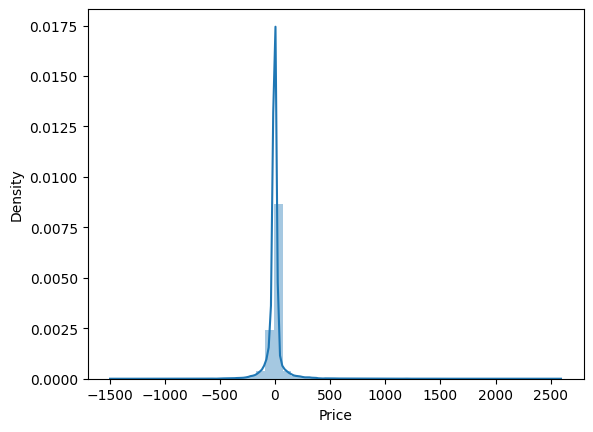

In [ ]:
sns.distplot(y_test - pred)


Text(0, 0.5, 'pred')

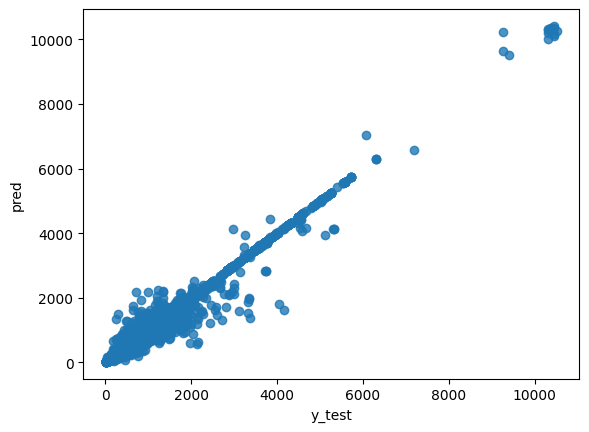

In [ ]:
plt.scatter(y_test , pred , alpha=0.8)
plt.xlabel('y_test')
plt.ylabel('pred')



In [ ]:
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test, pred))
print('MSE:', metrics.mean_squared_error(y_test, pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, pred)))

MAE: 34.181552351328556
MSE: 9769.716443933203
RMSE: 98.84187596324345


In [ ]:
metrics.r2_score(y_test,pred)


0.9824858672367018

In [ ]:
# Stage 1 - Original Data - Random Forest
rf_mae_original = metrics.mean_absolute_error(y_test, pred)
rf_mse_original = metrics.mean_squared_error(y_test, pred)
rf_rmse_original = np.sqrt(metrics.mean_squared_error(y_test, pred))
rf_r2_original = metrics.r2_score(y_test,pred)


print('MAE:', rf_mae_original)
print('MSE:', rf_mse_original)
print('RMSE:', rf_rmse_original)
print('R2:', rf_r2_original)


MAE: 34.428813791649084
MSE: 10012.587444348375
RMSE: 100.06291742872769
R2: 0.9820504733365781


In [ ]:
# Create a DataFrame for actual vs predicted values
original_random_results_df = pd.DataFrame({
    'Price': y_test.values,        # Actual prices
    'Predicted Price': pred        # Predicted prices
})

# Display the first 20 rows of the DataFrame
print(original_random_results_df.head(20))

     Price  Predicted Price
0     83.0            67.93
1    954.0           965.46
2    176.0           160.00
3    322.0           410.70
4   2306.0          2306.00
5    213.0           213.00
6    138.0           138.00
7    269.0           279.12
8    378.0           434.91
9    208.0           215.39
10   424.0           783.16
11   297.0           297.00
12   165.0           186.88
13   124.0           134.16
14    66.0            60.91
15   178.0           179.73
16   268.0           268.00
17   349.0           349.05
18   767.0           729.81
19   245.0           264.97


### Applying hyperparameters searching tools like Random_Search and including the regularization options into model, however in RandomForest models, there is no direct concept of regularization like L1 (Lasso) or L2 (Ridge) as in linear models. Random forests achieve regularization through other mechanisms such as:


1.   Limiting the tree depth (max_depth): By restricting how deep each tree in the forest can go, you effectively prevent the model from overfitting to the training data.
2.   Limiting the number of features considered at each split (max_features): This controls the randomness in feature selection for splitting, which helps in preventing overfitting.
3.   Increasing min_samples_split or min_samples_leaf: This makes the model more conservative, ensuring that splits only occur when there is enough data, which reduces overfitting.
4.   Using fewer trees (n_estimators): More trees tend to increase model complexity but might lead to overfitting if the model becomes too complex.



### Stage 2 : Fit Original Dataset Into Random Forest with RandomizedSearchCV + Regularization

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import randint

# Define your data
X = flight_df.drop(columns='Price', axis=1)
y = flight_df['Price']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=51)

# RandomForest model initialization
rfr = RandomForestRegressor()

# Define the hyperparameter grid for RandomizedSearchCV to apply regularization-like constraints
param_dist = {
    'n_estimators': randint(100, 1000),  # Number of trees
    'max_depth': randint(10, 50),        # Maximum depth of each tree (limits overfitting)
    'min_samples_split': randint(2, 10), # Minimum samples required to split a node
    'min_samples_leaf': randint(1, 5),   # Minimum samples at each leaf
    'max_features':['sqrt', 'log2'],  # Number of features to consider at each split
    'bootstrap': [True, False]           # Whether to bootstrap the samples
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    rfr, param_distributions=param_dist, n_iter=10, cv=5, random_state=42, n_jobs=-1
)

# Fit the model with RandomizedSearchCV
random_search.fit(X_train, y_train)

# Best parameters
print("Best parameters found: ", random_search.best_params_)



/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters found:  {'bootstrap': False, 'max_depth': 25, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 7, 'n_estimators': 786}


In [ ]:
# Predict using the best model
best_rfr = random_search.best_estimator_
y_pred = best_rfr.predict(X_test)

# Calculate metrics
print('MAE:', mean_absolute_error(y_test, y_pred))
print('MSE:', mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R²:', r2_score(y_test, y_pred))


MAE: 45.70279104377008
MSE: 12811.831583604819
RMSE: 113.18936161850556
R²: 0.977032279228983


In [ ]:
# Stage 2 - Random Search + Regularization

# Random Forest
rf_mae_random =  mean_absolute_error(y_test, y_pred)
rf_mse_random =  mean_squared_error(y_test, y_pred)
rf_rmse_random = np.sqrt(mean_squared_error(y_test, y_pred))
rf_r2_random =  r2_score(y_test, y_pred)


print('MAE:', rf_mae_random)
print('MSE:', rf_mse_random)
print('RMSE:', rf_rmse_random)
print('R2:', rf_r2_random)


MAE: 45.70279104377008
MSE: 12811.831583604819
RMSE: 113.18936161850556
R2: 0.977032279228983


In [ ]:

# Price vs Predicted Price DataFrame
results_df = pd.DataFrame({
    'Price': y_test.values,
    'Predicted Price': y_pred
})

# Display first few rows
print(results_df.head(20))



     Price  Predicted Price
0     83.0        53.877315
1    954.0       984.735277
2    176.0       150.558598
3    322.0       337.470568
4   2306.0      2307.712756
5    213.0       214.472649
6    138.0       145.153680
7    269.0       292.086822
8    378.0       339.696337
9    208.0       230.698187
10   424.0       604.988530
11   297.0       301.837494
12   165.0       177.150422
13   124.0       159.413565
14    66.0        68.778151
15   178.0       184.523394
16   268.0       267.798838
17   349.0       360.999689
18   767.0       782.842563
19   245.0       294.096844


###  Removing Outliers

In [ ]:
# Select only the numeric columns from the dataset
numeric_cols = flight_df.select_dtypes(include=[np.number])

# Calculate Q1 (25th percentile) and Q3 (75th percentile) for numeric columns
Q1 = numeric_cols.quantile(0.05)
Q3 = numeric_cols.quantile(0.95)

# Calculate the IQR (Interquartile Range)
IQR = Q3 - Q1

# Define a mask for outliers: Any value below Q1 - 1.5 * IQR or above Q3 + 1.5 * IQR is considered an outlier
outlier_mask = (numeric_cols < (Q1 - 1.5 * IQR)) | (numeric_cols > (Q3 + 1.5 * IQR))

# Filter out the outliers
numeric_cols_no_outliers = numeric_cols[~outlier_mask.any(axis=1)]

# Replace the numeric columns in the original dataframe with the filtered ones
flight_df_no_outliers = flight_df.loc[numeric_cols_no_outliers.index]

print(f"Original data shape: {flight_df.shape}")
print(f"Data shape after removing outliers: {flight_df_no_outliers.shape}")



Original data shape: (94837, 105)
Data shape after removing outliers: (40805, 105)


In [ ]:
# Identify duplicate column labels
duplicate_columns = flight_df_no_outliers.columns[flight_df_no_outliers.columns.duplicated()].unique()
if len(duplicate_columns) > 0:
    print(f"Duplicate column labels found: {duplicate_columns}")
else:
    print("No duplicate column labels found.")


No duplicate column labels found.


In [ ]:
X_no_outliers = flight_df_no_outliers.drop(columns='Price',axis=1)
y_no_outliers = flight_df_no_outliers['Price']
X_no_outliers.head()

,Duration,Total Duration,Layover 1 Duration,Layover 1 Overnight,Cabin Baggage,Checked Baggage,Meal Included,Cabin Baggage (Number),Cabin Baggage (kg per piece),Checked Baggage (Number),...,Final Arrival Airport ID_RGN,Final Arrival Airport ID_SGN,Final Arrival Airport ID_SIN,Final Arrival Airport ID_VTE,Travel Class_Economy,Travel Class_First Class,Travel Class_Premium Economy,Time of Day_Evening,Time of Day_Morning,Flight Type_Layover
2,90,90,0,0,1,1,1,1,7,2,...,0,0,0,0,1,0,0,0,1,0
3,90,90,0,0,1,1,1,1,7,2,...,0,0,0,0,1,0,0,1,0,0
4,175,670,355,0,1,1,1,1,7,1,...,0,0,0,0,1,0,0,0,1,1
10,90,90,0,0,1,1,1,1,7,2,...,0,0,0,0,1,0,0,0,1,0
11,90,90,0,0,1,1,1,1,7,2,...,0,0,0,0,1,0,0,1,0,0


In [ ]:

from sklearn.model_selection import train_test_split
X_train_no_outliers , X_test_no_outliers , y_train_no_outliers , y_test_no_outliers = train_test_split(X_no_outliers,y_no_outliers,test_size=0.2 , random_state=51)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor()
rfr.fit(X_train_no_outliers , y_train_no_outliers)

RandomForestRegressor()

In [ ]:
pred_no_outliers = rfr.predict(X_test_no_outliers)

In [ ]:
rfr.score(X_train_no_outliers , y_train_no_outliers)


0.9946704845866219

In [ ]:
rfr.score(X_test_no_outliers , y_test_no_outliers)


0.9701150980150447

<ipython-input-46-9a8d8e00bac4>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_test_no_outliers - pred_no_outliers)


<Axes: xlabel='Price', ylabel='Density'>

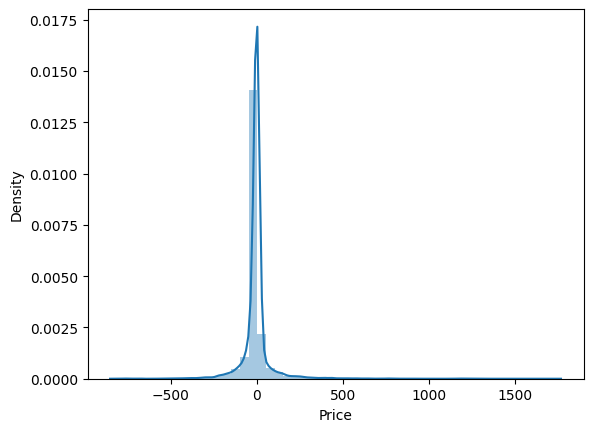

In [ ]:
sns.distplot(y_test_no_outliers - pred_no_outliers)

Text(0, 0.5, 'pred')

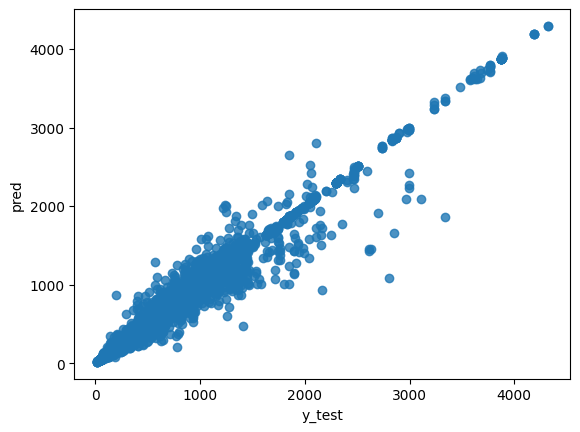

In [ ]:
plt.scatter(y_test_no_outliers , pred_no_outliers , alpha=0.8)
plt.xlabel('y_test')
plt.ylabel('pred')

In [ ]:
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test_no_outliers, pred_no_outliers))
print('MSE:', metrics.mean_squared_error(y_test_no_outliers, pred_no_outliers))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test_no_outliers, pred_no_outliers)))

MAE: 34.47197034677123
MSE: 8698.10499628722
RMSE: 93.2636316914971


In [ ]:
metrics.r2_score(y_test_no_outliers,pred_no_outliers)


0.9701150980150447

In [ ]:
# Create a DataFrame for actual vs predicted values
original_random_results_df_no_outliers = pd.DataFrame({
    'Price': y_test_no_outliers.values,        # Actual prices
    'Predicted Price': pred_no_outliers        # Predicted prices
})

# Display the first 20 rows of the DataFrame
print(original_random_results_df_no_outliers.head(20))

     Price  Predicted Price
0     58.0            58.48
1    194.0           194.00
2    576.0           599.20
3    297.0           305.34
4    178.0           178.00
5    232.0           232.35
6   1178.0          1382.26
7   1182.0          1200.49
8     54.0            53.72
9    648.0           648.00
10    99.0           101.63
11  1021.0          1024.02
12   186.0           169.01
13   444.0           571.59
14   152.0           152.00
15   581.0           591.86
16   241.0           244.52
17   213.0           236.92
18   984.0          1118.06
19   306.0           314.06


### Stage 1 : Fit Original Dataset Into XGBoost

In [ ]:
pip install xgboost


In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd
import numpy as np


In [ ]:
X = flight_df.drop(columns='Price',axis=1)
y = flight_df['Price']
X.head()

,Duration,Total Duration,Layover 1 Duration,Layover 1 Overnight,Cabin Baggage,Checked Baggage,Meal Included,Cabin Baggage (Number),Cabin Baggage (kg per piece),Checked Baggage (Number),...,Final Arrival Airport ID_RGN,Final Arrival Airport ID_SGN,Final Arrival Airport ID_SIN,Final Arrival Airport ID_VTE,Travel Class_Economy,Travel Class_First Class,Travel Class_Premium Economy,Time of Day_Evening,Time of Day_Morning,Flight Type_Layover
0,85,85,0,0,1,1,1,1,7,1,...,0,0,0,0,1,0,0,0,0,0
1,85,85,0,0,1,1,1,1,7,1,...,0,0,0,0,1,0,0,0,1,0
2,90,90,0,0,1,1,1,1,7,2,...,0,0,0,0,1,0,0,0,1,0
3,90,90,0,0,1,1,1,1,7,2,...,0,0,0,0,1,0,0,1,0,0
4,175,670,355,0,1,1,1,1,7,1,...,0,0,0,0,1,0,0,0,1,1


In [ ]:

# Split the data into training and test sets
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Convert the data into DMatrix, which is the optimized data structure that XGBoost uses
dtrain_xgb = xgb.DMatrix(X_train_xgb, label=y_train_xgb)
dtest_xgb = xgb.DMatrix(X_test_xgb, label=y_test_xgb)

# Set the parameters for XGBoost
params = {
    'objective': 'reg:squarederror',  # This specifies a regression task
    'max_depth': 6,  # The maximum depth of a tree
    'eta': 0.1,  # Step size shrinkage (learning rate)
    'subsample': 0.8,  # Subsample ratio of the training instances
    'colsample_bytree': 0.8,  # Subsample ratio of columns when constructing each tree
    'nthread': 4,  # Number of threads to use
    'seed': 42  # Random seed for reproducibility
}

# Train the model
num_rounds = 100  # Number of boosting rounds
model = xgb.train(params, dtrain_xgb, num_rounds)


In [ ]:
# Make predictions
y_pred_xgb = model.predict(dtest_xgb)

# Evaluate the model
mse_xgb = mean_squared_error(y_test_xgb, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
mae_xgb = mean_absolute_error(y_test_xgb, y_pred_xgb)
r2_xgb = r2_score(y_test_xgb, y_pred_xgb)

print(f"XGBoost Model Performance:")
print(f"Mean Absolute Error (MAE): {mae_xgb}")
print(f"Mean Squared Error (MSE): {mse_xgb}")
print(f"Root Mean Squared Error (RMSE): {rmse_xgb}")
print(f"R^2 Score: {r2_xgb}")


XGBoost Model Performance:
Mean Absolute Error (MAE): 88.35428405501882
Mean Squared Error (MSE): 26282.180857103824
Root Mean Squared Error (RMSE): 162.11779932229473
R^2 Score: 0.9523441793838602


In [ ]:
# Stage 1 - Original Data - XGBoost
xgb_mae_original = mae_xgb
xgb_mse_original = mse_xgb
xgb_rmse_original = rmse_xgb
xgb_r2_original = r2_xgb


print('MAE:', xgb_mae_original)
print('MSE:', xgb_mse_original)
print('RMSE:', xgb_rmse_original)
print('R2:', xgb_r2_original)


MAE: 88.35428405501882
MSE: 26282.180857103824
RMSE: 162.11779932229473
R2: 0.9523441793838602


In [ ]:
# Create a DataFrame for actual vs predicted values
results_df_xgb = pd.DataFrame({
    'Price': y_test_xgb,  # Actual prices
    'Predicted Price': y_pred_xgb  # Predicted prices
})

# Display the first few rows of the DataFrame (Price vs Predicted Price)
print(results_df_xgb.head(20))  # You can adjust the number of rows as needed


        Price  Predicted Price
87299  1337.0      1148.885864
15294    78.0       280.512146
40539   214.0       181.186462
1801    174.0        99.641129
11189   102.0        93.557625
21567    47.0        45.275932
10592   199.0       215.259033
8449    235.0       253.059677
43892   149.0       154.806915
60158   851.0       960.293152
29560   360.0       407.481781
65959   505.0       772.853821
91872   837.0      1030.761841
90039  1305.0       973.335693
19821    91.0       122.121910
26164   112.0        84.943977
15057   302.0       327.935852
70      154.0       117.611206
58299  1045.0       958.781250
56328  1877.0      1944.251343


### Stage 2 : Fit Original Dataset Into XGBoost with RandomizedSearchCV + Regularization

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor

# Define the model
xgb_model = XGBRegressor(objective='reg:squarederror')

# Define the parameters to tune
param_grid = {
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'reg_alpha': [0, 0.01, 0.1, 1],   # L1 regularization (Lasso)
    'reg_lambda': [1, 0.1, 0.01, 0]   # L2 regularization (Ridge)
}

# Set up RandomizedSearchCV
randomized_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=50,
    cv=3,
    scoring='neg_mean_squared_error',
    verbose=1,
    random_state=42,
    n_jobs=-1  # Use all available CPU cores
)

# Fit the randomized search
randomized_search.fit(X_train_xgb, y_train_xgb)

# Print the best parameters and score
print(f"Best Parameters: {randomized_search.best_params_}")
print(f"Best Score: {-randomized_search.best_score_}")

# Train the final model with the best parameters
best_xgb_model = randomized_search.best_estimator_
best_xgb_model.fit(X_train_xgb, y_train_xgb)

# Evaluate the final model
y_pred_best_xgb = best_xgb_model.predict(X_test_xgb)

mse_best_xgb = mean_squared_error(y_test_xgb, y_pred_best_xgb)
rmse_best_xgb = np.sqrt(mse_best_xgb)
mae_best_xgb = mean_absolute_error(y_test_xgb, y_pred_best_xgb)
r2_best_xgb = r2_score(y_test_xgb, y_pred_best_xgb)

print(f"Optimized XGBoost Model Performance:")
print(f"Mean Absolute Error (MAE): {mae_best_xgb}")
print(f"Mean Squared Error (MSE): {mse_best_xgb}")
print(f"Root Mean Squared Error (RMSE): {rmse_best_xgb}")
print(f"R^2 Score: {r2_best_xgb}")




Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'subsample': 0.8, 'reg_lambda': 1, 'reg_alpha': 0.01, 'n_estimators': 300, 'max_depth': 9, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
Best Score: 9200.44605997748
Optimized XGBoost Model Performance:
Mean Absolute Error (MAE): 38.80115493436948
Mean Squared Error (MSE): 8782.943619415146
Root Mean Squared Error (RMSE): 93.7173602883433
R^2 Score: 0.9840744423804014


In [ ]:
# Stage 2 - Random Search + Regularization

# XGBoost
xgb_mae_random =  mae_best_xgb
xgb_mse_random =  mse_best_xgb
xgb_rmse_random = rmse_best_xgb
xgb_r2_random =  r2_best_xgb


print('MAE:', xgb_mae_random)
print('MSE:', xgb_mse_random)
print('RMSE:', xgb_rmse_random)
print('R2:', xgb_r2_random)


MAE: 38.80115493436948
MSE: 8782.943619415146
RMSE: 93.7173602883433
R2: 0.9840744423804014


In [ ]:
# Create a DataFrame for actual vs predicted values
results_df_best_xgb = pd.DataFrame({
    'Actual Price': y_test_xgb,  # Actual prices
    'Predicted Price': y_pred_best_xgb  # Predicted prices
})

# Display the first few rows of the DataFrame (Actual Price vs Predicted Price)
print(results_df_best_xgb.head(20))

       Actual Price  Predicted Price
87299        1337.0      1258.264526
15294          78.0       111.454720
40539         214.0       218.474487
1801          174.0       154.324875
11189         102.0        99.617386
21567          47.0        49.907352
10592         199.0       209.343597
8449          235.0       226.085999
43892         149.0       134.444778
60158         851.0       877.809753
29560         360.0       389.964935
65959         505.0       532.060303
91872         837.0       872.776672
90039        1305.0       945.626892
19821          91.0       106.351685
26164         112.0       105.983444
15057         302.0       352.724091
70            154.0       155.206512
58299        1045.0       905.278870
56328        1877.0      1943.327148


### Stage 1 : Fit Original Dataset Into LightGBM

In [ ]:
pip install lightgbm


In [ ]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd
import gc


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
# Load the flight dataset
flight_df = pd.read_csv('flight_ready_data.csv')

# Separate features and target
X = flight_df.drop(columns='Price', axis=1)
y = flight_df['Price']


In [ ]:

# Split the data into training and test sets
X_train_lgb, X_test_lgb, y_train_lgb, y_test_lgb = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the LightGBM dataset
lgb_train = lgb.Dataset(X_train_lgb, label=y_train_lgb)
lgb_test = lgb.Dataset(X_test_lgb, label=y_test_lgb, reference=lgb_train)

# Set the hyperparameters
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.01,  # Lower the learning rate
    'num_leaves': 40,       # Increase the complexity
    'max_depth': -1,
    'min_data_in_leaf': 20,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1
}

# Define the callback for early stopping
early_stopping_callback = lgb.early_stopping(stopping_rounds=100)

# Train the model with early stopping using a callback
lgb_model = lgb.train(params,
                      lgb_train,
                      num_boost_round=5000,
                      valid_sets=[lgb_test],
                      callbacks=[early_stopping_callback])



Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[5000]	valid_0's rmse: 102.546


In [ ]:
# Make predictions on the test set
y_pred_lgb = lgb_model.predict(X_test_lgb, num_iteration=lgb_model.best_iteration)

# Evaluate the model
mae_lgb = mean_absolute_error(y_test_lgb, y_pred_lgb)
mse_lgb = mean_squared_error(y_test_lgb, y_pred_lgb)
rmse_lgb = np.sqrt(mse_lgb)
r2_lgb = r2_score(y_test_lgb, y_pred_lgb)

# Print the model performance
print(f"LightGBM Model Performance:")
print(f"Mean Absolute Error (MAE): {mae_lgb}")
print(f"Mean Squared Error (MSE): {mse_lgb}")
print(f"Root Mean Squared Error (RMSE): {rmse_lgb}")
print(f"R^2 Score: {r2_lgb}")


LightGBM Model Performance:
Mean Absolute Error (MAE): 48.32659703223042
Mean Squared Error (MSE): 10515.616356449938
Root Mean Squared Error (RMSE): 102.54567936510021
R^2 Score: 0.9809326962067657


In [ ]:
# Stage 1 - Original Data - LightGBM
lgb_mae_original = mae_lgb
lgb_mse_original = mse_lgb
lgb_rmse_original = rmse_lgb
lgb_r2_original = r2_lgb


print('MAE:', lgb_mae_original)
print('MSE:', lgb_mse_original)
print('RMSE:', lgb_rmse_original)
print('R2:', lgb_r2_original)


MAE: 48.32659703223042
MSE: 10515.616356449938
RMSE: 102.54567936510021
R2: 0.9809326962067657


In [ ]:
# Create a DataFrame for actual vs predicted values
results_df_lgb = pd.DataFrame({
    'Actual Price': y_test_lgb,  # Actual prices
    'Predicted Price': y_pred_lgb  # Predicted prices
})

# Display the first few rows of the DataFrame (Actual Price vs Predicted Price)
print(results_df_lgb.head(20))

       Actual Price  Predicted Price
87299        1337.0      1196.448944
15294          78.0       141.649592
40539         214.0       201.002913
1801          174.0       132.190853
11189         102.0       115.509624
21567          47.0        57.405140
10592         199.0       205.364302
8449          235.0       241.264564
43892         149.0       173.224912
60158         851.0       888.024551
29560         360.0       371.297827
65959         505.0       529.196766
91872         837.0       902.596803
90039        1305.0       968.358048
19821          91.0       106.517329
26164         112.0        91.944100
15057         302.0       298.805721
70            154.0       148.200099
58299        1045.0       865.789224
56328        1877.0      1936.148512


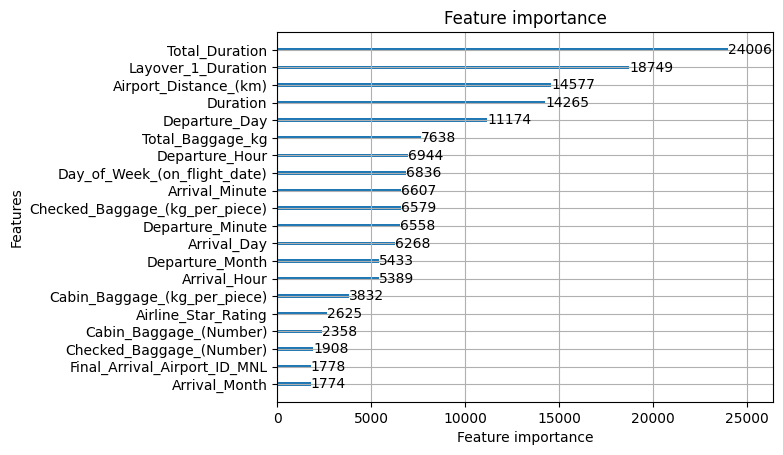

In [ ]:
import matplotlib.pyplot as plt

# Plot feature importance
lgb.plot_importance(lgb_model, max_num_features=20, importance_type='split')
plt.show()

### Stage 2 : Fit Original Dataset Into LightGBM with RandomizedSearchCV + Regularization

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Define your LightGBM model
lgb_model = lgb.LGBMRegressor(boosting_type='gbdt', objective='regression', metric='rmse')

# Set up the parameter grid for RandomizedSearchCV, including L1 and L2 regularization
param_grid = {
    'learning_rate': [0.005, 0.01, 0.02],  # Learning rate
    'num_leaves': [31, 40, 50],            # Number of leaves in one tree
    'min_data_in_leaf': [10, 20, 30],      # Minimum data in a leaf
    'feature_fraction': [0.7, 0.8, 0.9],   # Fraction of features to consider
    'bagging_fraction': [0.7, 0.8, 0.9],   # Fraction of data to consider
    'bagging_freq': [5, 10],               # Bagging frequency
    'reg_alpha': [0.0, 0.1, 0.5, 1.0],     # L1 regularization (Lasso)
    'reg_lambda': [0.0, 0.1, 0.5, 1.0]     # L2 regularization (Ridge)
}

# Set up RandomizedSearchCV
randomized_search = RandomizedSearchCV(
    estimator=lgb_model,
    param_distributions=param_grid,
    n_iter=50,  # Number of parameter settings that are sampled
    cv=3,       # 3-fold cross-validation
    scoring='neg_mean_squared_error',
    verbose=1,
    random_state=42,
    n_jobs=-1  # Use all available CPU cores
)

# Fit the randomized search
randomized_search.fit(X_train_lgb, y_train_lgb)

# Print the best parameters and score
print(f"Best Parameters: {randomized_search.best_params_}")
print(f"Best Score (Negative MSE): {-randomized_search.best_score_}")




Fitting 3 folds for each of 50 candidates, totalling 150 fits
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bag

In [ ]:
# Train the final model with the best parameters
best_lgb_model = randomized_search.best_estimator_
best_lgb_model.fit(X_train_lgb, y_train_lgb)

# Make predictions on the test set
y_pred_best_lgb = best_lgb_model.predict(X_test_lgb)

# Evaluate the final model
mse_best_lgb = mean_squared_error(y_test_lgb, y_pred_best_lgb)
rmse_best_lgb = np.sqrt(mse_best_lgb)
mae_best_lgb = mean_absolute_error(y_test_lgb, y_pred_best_lgb)
r2_best_lgb = r2_score(y_test_lgb, y_pred_best_lgb)

print(f"Optimized LightGBM Model Performance:")
print(f"Mean Absolute Error (MAE): {mae_best_lgb}")
print(f"Mean Squared Error (MSE): {mse_best_lgb}")
print(f"Root Mean Squared Error (RMSE): {rmse_best_lgb}")
print(f"R² Score: {r2_best_lgb}")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current 

In [ ]:
# Stage 2 - Random Search + Regularization

# LightGBM
lgb_mae_random =  mae_best_lgb
lgb_mse_random =  mse_best_lgb
lgb_rmse_random = rmse_best_lgb
lgb_r2_random =  r2_best_lgb


print('MAE:', lgb_mae_random)
print('MSE:', lgb_mse_random)
print('RMSE:', lgb_rmse_random)
print('R2:', lgb_r2_random)


MAE: 146.8971705179235
MSE: 57971.780253147685
RMSE: 240.77329638717762
R2: 0.8948834278417366


In [ ]:
# Create a DataFrame for actual vs predicted values
results_df_best_lgb = pd.DataFrame({
    'Actual Price': y_test_lgb,  # Actual prices
    'Predicted Price': y_pred_best_lgb  # Predicted prices
})

# Display the first few rows of the DataFrame (Actual Price vs Predicted Price)
print(results_df_best_lgb.head(20))

       Actual Price  Predicted Price
87299        1337.0       972.886367
15294          78.0       267.055954
40539         214.0       212.112008
1801          174.0       197.141420
11189         102.0       163.056386
21567          47.0       166.945603
10592         199.0       238.822841
8449          235.0       242.760640
43892         149.0       197.998084
60158         851.0       885.888600
29560         360.0       433.922957
65959         505.0       845.235289
91872         837.0       986.002335
90039        1305.0       942.554282
19821          91.0       194.024865
26164         112.0       171.124157
15057         302.0       378.497822
70            154.0       195.696365
58299        1045.0       901.660214
56328        1877.0      1634.265730


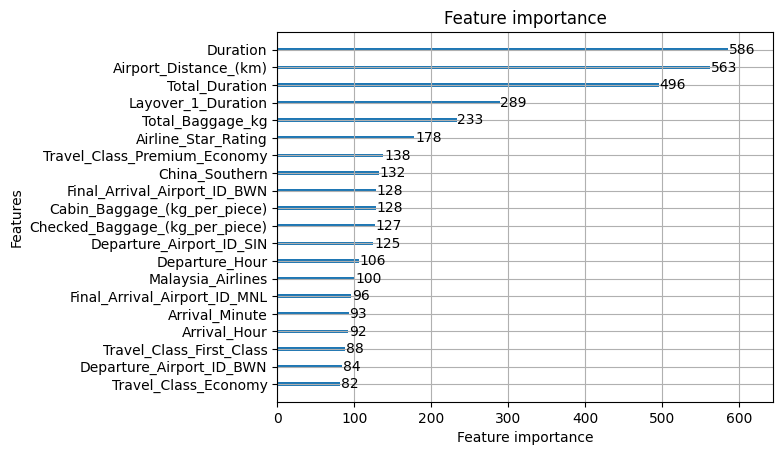

In [ ]:
# Plot feature importance
lgb.plot_importance(best_lgb_model, max_num_features=20, importance_type='split')
plt.show()

### Polynomial Feature and Log transformation


In [ ]:
import pandas as pd
from sklearn.preprocessing import FunctionTransformer
import numpy as np

# Load the dataset
X = pd.read_csv('flight_ready_data.csv').drop(columns='Price', axis=1)

# Initialize the log transformer
log_transformer = FunctionTransformer(np.log1p, validate=True)

# Apply log transformation to the numeric columns
X_log = log_transformer.fit_transform(X.select_dtypes(include=[np.number]))

# Convert the transformed data to a DataFrame
X_log_df = pd.DataFrame(X_log, columns=X.columns)

# Save the log-transformed data to a CSV file
X_log_df.to_csv('X_log.csv', index=False)
print("Log transformation applied and saved.")


Log transformation applied and saved.


In [ ]:
from sklearn.preprocessing import PolynomialFeatures

# Load the log-transformed data
X_log_df = pd.read_csv('X_log.csv')

# Initialize PolynomialFeatures
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)

# Generate polynomial features
X_poly = poly.fit_transform(X_log_df)

# Convert to DataFrame and save to disk
X_poly_df = pd.DataFrame(X_poly, columns=poly.get_feature_names_out(X_log_df.columns))
X_poly_df.to_csv('X_poly.csv', index=False)
print("Polynomial features generated and saved after log transformation.")


Polynomial features generated and saved after log transformation.


In [ ]:
import pandas as pd
from sklearn.preprocessing import FunctionTransformer
import numpy as np

# Load the final transformed data
X_poly_df = pd.read_csv('X_poly.csv')

# Check the number of columns in the DataFrame
X_poly_df_num_columns = X_poly_df.shape[1]
print(f"Number of columns in X_binned_df: {X_poly_df_num_columns}")


Number of columns in X_binned_df: 5460


In [ ]:

# Load the final transformed data
X_log_df = pd.read_csv('X_log.csv')

# Check the number of columns in the DataFrame
X_log_df_num_columns = X_log_df.shape[1]
print(f"Number of columns in X_binned_df: {X_log_df_num_columns}")


Number of columns in X_binned_df: 104


### Stage 3:   Fit Log, Polynomial then KFold Dataset Into Random Forest

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Define a chunk size
chunk_size = 10000

# Load your data in chunks
X_iterator = pd.read_csv('X_poly.csv', chunksize=chunk_size)
y = pd.read_csv('flight_ready_data.csv')['Price']

# Initialize the RandomForest model
rfr = RandomForestRegressor(n_estimators=100)

# Initialize lists to store metrics and actual/predicted values
mae_list = []
mse_list = []
rmse_list = []
r2_list = []
actual_values_list = []
predicted_values_list = []

# Iterate over each chunk of the data
for chunk_index, X_chunk in enumerate(X_iterator):
    print(f"Processing chunk {chunk_index+1}")

    # Corresponding target values for this chunk
    y_chunk = y.iloc[X_chunk.index]

    # Initialize KFold for this chunk
    kf = KFold(n_splits=5, shuffle=True, random_state=42)  # Using 5 splits per chunk to reduce computation time

    for train_index, test_index in kf.split(X_chunk):
        X_train, X_test = X_chunk.iloc[train_index], X_chunk.iloc[test_index]
        y_train, y_test = y_chunk.iloc[train_index], y_chunk.iloc[test_index]

        # Train the model on this fold
        rfr.fit(X_train, y_train)

        # Predict on the test set
        y_pred = rfr.predict(X_test)

        # Store actual and predicted values
        actual_values_list.extend(y_test.values)
        predicted_values_list.extend(y_pred)

        # Calculate metrics
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)

        # Append metrics to their respective lists
        mae_list.append(mae)
        mse_list.append(mse)
        rmse_list.append(rmse)
        r2_list.append(r2)



Processing chunk 1
Processing chunk 2
Processing chunk 3
Processing chunk 4
Processing chunk 5
Processing chunk 6
Processing chunk 7
Processing chunk 8
Processing chunk 9
Processing chunk 10


In [ ]:
# Calculate overall metrics (mean across all chunks and folds)
overall_mae = np.mean(mae_list)
overall_mse = np.mean(mse_list)
overall_rmse = np.mean(rmse_list)
overall_r2 = np.mean(r2_list)

print(f"Overall MAE: {overall_mae}")
print(f"Overall MSE: {overall_mse}")
print(f"Overall RMSE: {overall_rmse}")
print(f"Overall R²: {overall_r2}")



Overall MAE: 34.65418854343159
Overall MSE: 10100.698677480037
Overall RMSE: 87.47285619402068
Overall R²: 0.9679581624540978


In [ ]:
# Stage 3 - Log Transformation, Polynomial Features + KFold

# Random Forest
rf_mae_kfold =  overall_mae
rf_mse_kfold =  overall_mse
rf_rmse_kfold =  overall_rmse
rf_r2_kfold =  overall_r2

print(rf_mae_kfold)
print(rf_mse_kfold)
print(rf_rmse_kfold)
print(rf_r2_kfold)

34.65418854343159
10100.698677480037
87.47285619402068
0.9679581624540978


In [ ]:
# Create a DataFrame for actual vs predicted values
results_df_random = pd.DataFrame({
    'Price': actual_values_list,
    'Predicted Price': predicted_values_list
})

# Display the first few rows of the DataFrame (Price vs Predicted Price)
print(results_df_random.head(20))

    Price  Predicted Price
0    93.0            92.62
1   138.0           143.60
2   154.0           154.00
3   138.0           113.32
4   258.0           284.11
5   154.0           154.00
6    93.0            94.92
7    94.0           101.73
8   127.0            96.21
9   154.0           154.00
10   94.0           103.09
11  154.0           154.00
12  154.0           154.00
13   73.0            84.65
14   93.0            74.43
15   94.0            93.36
16  258.0           258.18
17   94.0            94.74
18  154.0           154.00
19  154.0           154.00


In [ ]:
from sklearn.model_selection import cross_val_score
import numpy as np

def cross_validation(reg_model, X, y):
    try:
        # Perform cross-validation and calculate RMSE scores
        neg_mse_scores = cross_val_score(reg_model, X, y, scoring='neg_mean_squared_error', cv=10)
        rmse_scores = np.sqrt(-neg_mse_scores)

        # Print the RMSE scores, mean, and standard deviation
        print("\nRMSE Scores:", rmse_scores)
        print("Mean RMSE:", rmse_scores.mean())
        print("Standard Deviation of RMSE:", rmse_scores.std())

        # Return the scores for further analysis
        return rmse_scores

    except Exception as e:
        print(f"An error occurred during cross-validation: {e}")
        return None



In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

# Load your data in chunks
chunk_size = 10000  # Define a reasonable chunk size
X = pd.read_csv('X_poly.csv', chunksize=chunk_size)
y = pd.read_csv('flight_ready_data.csv')['Price']

# Initialize the RandomForest model
rfr = RandomForestRegressor(n_estimators=100)

# List to store RMSE scores for all chunks
random_all_rmse_scores = []

# Iterate over each chunk
for i, chunk in enumerate(X):
    print(f"Processing chunk {i+1}")
    random_rmse_scores = cross_validation(rfr, chunk, y.loc[chunk.index])
    if random_rmse_scores is not None:
        random_all_rmse_scores.extend(random_rmse_scores)

# Calculate the overall mean RMSE and standard deviation
random_overall_mean_rmse = np.mean(random_all_rmse_scores)
random_overall_std_rmse = np.std(random_all_rmse_scores)

print(f"Overall Cross-Validation RMSE Scores: {random_all_rmse_scores}")
print(f"Overall Mean RMSE: {random_overall_mean_rmse}")
print(f"Overall Standard Deviation of RMSE: {random_overall_std_rmse}")




Processing chunk 1

RMSE Scores: [127.82139613 145.69270052  74.00082467 119.08047478 123.12924077
 108.00305002 200.08305411 148.24269481  42.80610829  79.92055054]
Mean RMSE: 116.87800946564649
Standard Deviation of RMSE: 42.03631051232079
Processing chunk 2

RMSE Scores: [ 58.58466351  31.63355821  61.67917062  16.64333043 199.58407999
 470.98986562  82.05266615  68.89788704 194.97714235  65.90402421]
Mean RMSE: 125.09463881101655
Standard Deviation of RMSE: 129.43404596655125
Processing chunk 3

RMSE Scores: [ 18.89354693  25.57936191  48.45544252  42.41193399 172.62489486
 119.91529688  58.09997147  51.72442307 241.90067462 242.92156753]
Mean RMSE: 102.25271137676319
Standard Deviation of RMSE: 82.67930926876667
Processing chunk 4

RMSE Scores: [161.7726602   75.55276319  98.83738759  24.79074193  65.08199777
 111.7258497  116.15492196 470.90431754 168.72496622  77.18209916]
Mean RMSE: 137.07277052669306
Standard Deviation of RMSE: 118.64187466588915
Processing chunk 5

RMSE Score

### Stage 3:   Fit Log, Polynomial then KFold Dataset Into XGBoost

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Define a chunk size
chunk_size = 10000

# Load your data in chunks
X_iterator = pd.read_csv('X_poly.csv', chunksize=chunk_size)
y = pd.read_csv('flight_ready_data.csv')['Price']

# Initialize lists to store metrics and actual/predicted values for XGBoost
xgb_mae_list = []
xgb_mse_list = []
xgb_rmse_list = []
xgb_r2_list = []
xgb_actual_values_list = []
xgb_predicted_values_list = []

# Iterate over each chunk of the data
for chunk_index, X_chunk in enumerate(X_iterator):
    print(f"Processing chunk {chunk_index+1}")

    # Corresponding target values for this chunk
    y_chunk = y.iloc[X_chunk.index]

    # Initialize KFold for this chunk
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    for train_index, test_index in kf.split(X_chunk):
        X_train, X_test = X_chunk.iloc[train_index], X_chunk.iloc[test_index]
        y_train, y_test = y_chunk.iloc[train_index], y_chunk.iloc[test_index]

        # --------- XGBoost ---------
        xgb_model = xgb.XGBRegressor(n_estimators=100)
        xgb_model.fit(X_train, y_train)
        y_xgb_pred = xgb_model.predict(X_test)

        # Store actual and predicted values for XGBoost
        xgb_actual_values_list.extend(y_test.values)
        xgb_predicted_values_list.extend(y_xgb_pred)

        # Calculate metrics for XGBoost
        xgb_mae = mean_absolute_error(y_test, y_xgb_pred)
        xgb_mse = mean_squared_error(y_test, y_xgb_pred)
        xgb_rmse = np.sqrt(xgb_mse)
        xgb_r2 = r2_score(y_test, y_xgb_pred)

        # Append metrics to their respective lists
        xgb_mae_list.append(xgb_mae)
        xgb_mse_list.append(xgb_mse)
        xgb_rmse_list.append(xgb_rmse)
        xgb_r2_list.append(xgb_r2)



Processing chunk 1
Processing chunk 2
Processing chunk 3
Processing chunk 4
Processing chunk 5
Processing chunk 6
Processing chunk 7
Processing chunk 8
Processing chunk 9
Processing chunk 10


In [ ]:
# Calculate overall metrics for XGBoost (mean across all chunks and folds)
xgb_overall_mae = np.mean(xgb_mae_list)
xgb_overall_mse = np.mean(xgb_mse_list)
xgb_overall_rmse = np.mean(xgb_rmse_list)
xgb_overall_r2 = np.mean(xgb_r2_list)

print(f"XGBoost Overall MAE: {xgb_overall_mae}")
print(f"XGBoost Overall MSE: {xgb_overall_mse}")
print(f"XGBoost Overall RMSE: {xgb_overall_rmse}")
print(f"XGBoost Overall R²: {xgb_overall_r2}")


XGBoost Overall MAE: 38.02039411376228
XGBoost Overall MSE: 9613.289973108167
XGBoost Overall RMSE: 85.73488612615905
XGBoost Overall R²: 0.9696344154938409


In [ ]:
# Stage 3 - Log Transformation, Polynomial Features + KFold

# XGBoost
xgb_mae_kfold =  xgb_overall_mae
xgb_mse_kfold =  xgb_overall_mse
xgb_rmse_kfold =  xgb_overall_rmse
xgb_r2_kfold =  xgb_overall_r2

print(xgb_mae_kfold)
print(xgb_mse_kfold)
print(xgb_rmse_kfold)
print(xgb_r2_kfold)

38.02039411376228
9613.289973108167
85.73488612615905
0.9696344154938409


In [ ]:
# Create a DataFrame for actual vs predicted values for XGBoost
xgb_results_df = pd.DataFrame({
    'Price': xgb_actual_values_list,
    'Predicted Price': xgb_predicted_values_list
})

# Display the first few rows of the DataFrame (Price vs Predicted Price for XGBoost)
print(xgb_results_df.head(20))


    Price  Predicted Price
0    93.0       111.854813
1   138.0       128.799454
2   154.0       149.704391
3   138.0       100.735886
4   258.0       227.660263
5   154.0       156.067307
6    93.0       101.214828
7    94.0       105.287270
8   127.0        97.181747
9   154.0       154.333908
10   94.0       104.265350
11  154.0       149.982697
12  154.0       151.168228
13   73.0        85.901001
14   93.0        81.624374
15   94.0        91.441528
16  258.0       251.617279
17   94.0       105.089142
18  154.0       150.507904
19  154.0       151.851105


In [ ]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor

# Your custom cross-validation function
from sklearn.model_selection import cross_val_score


# Load your data in chunks
chunk_size = 10000  # Define a reasonable chunk size
X = pd.read_csv('X_poly.csv', chunksize=chunk_size)
y = pd.read_csv('flight_ready_data.csv')['Price']

# Initialize the XGBoost model
xgb_model = XGBRegressor(n_estimators=100, objective='reg:squarederror')

# List to store RMSE scores for all chunks
xgb_all_rmse_scores = []

# Iterate over each chunk
for i, chunk in enumerate(X):
    print(f"Processing chunk {i+1}")
    xgb_rmse_scores = cross_validation(xgb_model, chunk, y.loc[chunk.index])
    if xgb_rmse_scores is not None:
        xgb_all_rmse_scores.extend(xgb_rmse_scores)

# Calculate the overall mean RMSE and standard deviation
xgb_overall_mean_rmse = np.mean(xgb_all_rmse_scores)
xgb_overall_std_rmse = np.std(xgb_all_rmse_scores)

print(f"Overall Cross-Validation RMSE Scores: {xgb_all_rmse_scores}")
print(f"Overall Mean RMSE: {xgb_overall_mean_rmse}")
print(f"Overall Standard Deviation of RMSE: {xgb_overall_std_rmse}")


Processing chunk 1

RMSE Scores: [ 59.75807647 230.82127119  70.45441459 112.59328894 132.56174855
 111.46562428 225.53653934 196.33152047  45.52342675  83.03888172]
Mean RMSE: 126.80847922979774
Standard Deviation of RMSE: 64.85714569944355
Processing chunk 2

RMSE Scores: [ 56.92595943  32.3999798   58.70716012  14.56136783 201.55571367
 476.2968254   85.45939582  59.45586728 304.35336209  62.70027468]
Mean RMSE: 135.2415906128732
Standard Deviation of RMSE: 141.3965992743357
Processing chunk 3

RMSE Scores: [ 40.69076688  32.39395789  39.87508563  34.62993129 174.41283174
  73.08199804  47.50256588  49.30548691 246.98122647 246.86347543]
Mean RMSE: 98.57373261601855
Standard Deviation of RMSE: 84.09292172384399
Processing chunk 4

RMSE Scores: [141.02495826  73.18834619 102.15896034  24.88913171  56.19159479
  93.83140063  22.41244709 703.94875175 144.17599142 106.80154726]
Mean RMSE: 146.86231294257638
Standard Deviation of RMSE: 189.95167338940416
Processing chunk 5

RMSE Scores: 

### Stage 3:   Fit Log, Polynomial then KFold Dataset Into LightGBM

In [ ]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Define a chunk size
chunk_size = 10000

# Load your data in chunks
X_iterator = pd.read_csv('X_poly.csv', chunksize=chunk_size)
y = pd.read_csv('flight_ready_data.csv')['Price']

# Initialize lists to store metrics and actual/predicted values for LightGBM
lgb_mae_list = []
lgb_mse_list = []
lgb_rmse_list = []
lgb_r2_list = []
lgb_actual_values_list = []
lgb_predicted_values_list = []

# Iterate over each chunk of the data
for chunk_index, X_chunk in enumerate(X_iterator):
    print(f"Processing chunk {chunk_index+1}")

    # Corresponding target values for this chunk
    y_chunk = y.iloc[X_chunk.index]

    # Initialize KFold for this chunk
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    for train_index, test_index in kf.split(X_chunk):
        X_train, X_test = X_chunk.iloc[train_index], X_chunk.iloc[test_index]
        y_train, y_test = y_chunk.iloc[train_index], y_chunk.iloc[test_index]

        # --------- LightGBM ---------
        lgb_model = lgb.LGBMRegressor(n_estimators=100)
        lgb_model.fit(X_train, y_train)
        y_lgb_pred = lgb_model.predict(X_test)

        # Store actual and predicted values for LightGBM
        lgb_actual_values_list.extend(y_test.values)
        lgb_predicted_values_list.extend(y_lgb_pred)

        # Calculate metrics for LightGBM
        lgb_mae = mean_absolute_error(y_test, y_lgb_pred)
        lgb_mse = mean_squared_error(y_test, y_lgb_pred)
        lgb_rmse = np.sqrt(lgb_mse)
        lgb_r2 = r2_score(y_test, y_lgb_pred)

        # Append metrics to their respective lists
        lgb_mae_list.append(lgb_mae)
        lgb_mse_list.append(lgb_mse)
        lgb_rmse_list.append(lgb_rmse)
        lgb_r2_list.append(lgb_r2)


Processing chunk 1
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.044236 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 29255
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 1413
[LightGBM] [Info] Start training from score 288.699750
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.044493 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 28992
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 1417
[LightGBM] [Info] Start training from score 287.929500
[

In [ ]:
# Calculate overall metrics for LightGBM (mean across all chunks and folds)
lgb_overall_mae = np.mean(lgb_mae_list)
lgb_overall_mse = np.mean(lgb_mse_list)
lgb_overall_rmse = np.mean(lgb_rmse_list)
lgb_overall_r2 = np.mean(lgb_r2_list)

print(f"LightGBM Overall MAE: {lgb_overall_mae}")
print(f"LightGBM Overall MSE: {lgb_overall_mse}")
print(f"LightGBM Overall RMSE: {lgb_overall_rmse}")
print(f"LightGBM Overall R²: {lgb_overall_r2}")



LightGBM Overall MAE: 47.24191638468265
LightGBM Overall MSE: 20363.171770686688
LightGBM Overall RMSE: 112.17564670543878
LightGBM Overall R²: 0.7693974703172074


In [ ]:
# Stage 3 - Log Transformation, Polynomial Features + KFold

# LightGBM
lgb_mae_kfold =  lgb_overall_mae
lgb_mse_kfold =  lgb_overall_mse
lgb_rmse_kfold =  lgb_overall_rmse
lgb_r2_kfold =  lgb_overall_r2

print(lgb_mae_kfold)
print(lgb_mse_kfold)
print(lgb_rmse_kfold)
print(lgb_r2_kfold)

47.24191638468265
20363.171770686688
112.17564670543878
0.7693974703172074


In [ ]:
# Create a DataFrame for actual vs predicted values for LightGBM
lgb_results_df = pd.DataFrame({
    'Price': lgb_actual_values_list,
    'Predicted Price': lgb_predicted_values_list
})

# Display the first few rows of the DataFrame (Price vs Predicted Price for LightGBM)
print(lgb_results_df.head(20))


    Price  Predicted Price
0    93.0       101.613139
1   138.0       130.961101
2   154.0       157.020856
3   138.0       109.852679
4   258.0       259.381469
5   154.0       152.739527
6    93.0        94.748283
7    94.0       102.535335
8   127.0       101.019309
9   154.0       150.779884
10   94.0       104.128597
11  154.0       151.190433
12  154.0       151.670385
13   73.0        89.646362
14   93.0        91.842063
15   94.0        99.307641
16  258.0       257.889751
17   94.0       103.360088
18  154.0       148.660352
19  154.0       150.941064


In [ ]:
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor

# Your custom cross-validation function
from sklearn.model_selection import cross_val_score

# Load your data in chunks
chunk_size = 10000  # Define a reasonable chunk size
X = pd.read_csv('X_poly.csv', chunksize=chunk_size)
y = pd.read_csv('flight_ready_data.csv')['Price']

# Initialize the LightGBM model
lgb_model = LGBMRegressor(n_estimators=100)

# List to store RMSE scores for all chunks
all_rmse_scores = []

# Iterate over each chunk
for i, chunk in enumerate(X):
    print(f"Processing chunk {i+1}")
    rmse_scores = cross_validation(lgb_model, chunk, y.loc[chunk.index])
    if rmse_scores is not None:
        all_rmse_scores.extend(rmse_scores)

# Calculate the overall mean RMSE and standard deviation
overall_mean_rmse = np.mean(all_rmse_scores)
overall_std_rmse = np.std(all_rmse_scores)

print(f"Overall Cross-Validation RMSE Scores: {all_rmse_scores}")
print(f"Overall Mean RMSE: {overall_mean_rmse}")
print(f"Overall Standard Deviation of RMSE: {overall_std_rmse}")



/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


Processing chunk 1
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050279 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29046
[LightGBM] [Info] Number of data points in the train set: 9000, number of used features: 1425
[LightGBM] [Info] Start training from score 297.792111
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016238 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 28856
[LightGBM] [Info] Number of data points in the train set: 9000, number of used features: 1421
[LightGBM] [Info] Start training from score 276.708222
[LightGBM] [Warning] Found whitespace in feature_names, replace w

In [ ]:
#Stage 1 Original Data Comparison

# Create a table to display the metrics for RandomForest, XGBoost, and LightGBM
import pandas as pd

# Create a dictionary of results for each model
stage1_results_dict = {
    'Model': ['Random Forest', 'XGBoost', 'LightGBM'],
    'MAE': [rf_mae_original, xgb_mae_original, lgb_mae_original],
    'MSE': [rf_mse_original, xgb_mse_original, lgb_mse_original],
    'RMSE': [rf_rmse_original, xgb_rmse_original, lgb_rmse_original],
    'R²': [rf_r2_original, xgb_r2_original, lgb_r2_original]
}

# Convert to DataFrame
stage1_results_df_original = pd.DataFrame(stage1_results_dict)

# Display the table
print("First Stage: Original Data - Model Performance")
print(stage1_results_df_original)


First Stage: Original Data - Model Performance
           Model        MAE           MSE        RMSE        R²
0  Random Forest  34.428814  10012.587444  100.062917  0.982050
1        XGBoost  88.354284  26282.180857  162.117799  0.952344
2       LightGBM  48.326597  10515.616356  102.545679  0.980933


In [ ]:
#Stage 1 Original Data Comparison

# Display actual vs predicted price for each model
print("\nFirst 20 rows of Random Forest Predicted vs Actual Prices")
print(original_random_results_df.head(20))

print("\nFirst 20 rows of XGBoost Predicted vs Actual Prices")
print(results_df_xgb.head(20))

print("\nFirst 20 rows of LightGBM Predicted vs Actual Prices")
print(results_df_lgb.head(20))


First 20 rows of Random Forest Predicted vs Actual Prices
     Price  Predicted Price
0     83.0            67.93
1    954.0           965.46
2    176.0           160.00
3    322.0           410.70
4   2306.0          2306.00
5    213.0           213.00
6    138.0           138.00
7    269.0           279.12
8    378.0           434.91
9    208.0           215.39
10   424.0           783.16
11   297.0           297.00
12   165.0           186.88
13   124.0           134.16
14    66.0            60.91
15   178.0           179.73
16   268.0           268.00
17   349.0           349.05
18   767.0           729.81
19   245.0           264.97

First 20 rows of XGBoost Predicted vs Actual Prices
        Price  Predicted Price
87299  1337.0      1148.885864
15294    78.0       280.512146
40539   214.0       181.186462
1801    174.0        99.641129
11189   102.0        93.557625
21567    47.0        45.275932
10592   199.0       215.259033
8449    235.0       253.059677
43892   149.0       1

In [ ]:
#Stage 2 RandomSearched with Regularization Data Comparison

# Create a table to display the metrics for RandomForest, XGBoost, and LightGBM
import pandas as pd

# Create a dictionary of results for each model
stage2_results_dict = {
    'Model': ['Random Forest', 'XGBoost', 'LightGBM'],
    'MAE': [rf_mae_random, xgb_mae_random, lgb_mae_random],
    'MSE': [rf_mse_random, xgb_mse_random, lgb_mse_random],
    'RMSE': [rf_rmse_random, xgb_rmse_random, lgb_rmse_random],
    'R²': [rf_r2_random, xgb_r2_random, lgb_r2_random]
}

# Convert to DataFrame
stage2_results_df_original = pd.DataFrame(stage2_results_dict)

# Display the table
print("Second Stage: Original Data - Model Performance")
print(stage2_results_df_original)

Second Stage: Original Data - Model Performance
           Model         MAE           MSE        RMSE        R²
0  Random Forest   54.269770  15500.504396  124.501022  0.972212
1        XGBoost   38.801155   8782.943619   93.717360  0.984074
2       LightGBM  146.897171  57971.780253  240.773296  0.894883


In [ ]:
#Stage 2 RandomSearched with Regularization Data Comparison

# Display actual vs predicted price for each model
print("\nFirst 20 rows of Random Forest Predicted vs Actual Prices")
print(results_df.head(20))

print("\nFirst 20 rows of XGBoost Predicted vs Actual Prices")
print(results_df_best_xgb.head(20))

print("\nFirst 20 rows of LightGBM Predicted vs Actual Prices")
print(results_df_best_lgb.head(20))


First 20 rows of Random Forest Predicted vs Actual Prices
     Price  Predicted Price
0     83.0        54.938183
1    954.0       972.245938
2    176.0       156.036184
3    322.0       313.442831
4   2306.0      2311.201731
5    213.0       215.974690
6    138.0       155.248918
7    269.0       300.767029
8    378.0       315.058456
9    208.0       244.304924
10   424.0       640.362205
11   297.0       304.618020
12   165.0       191.567997
13   124.0       162.688565
14    66.0        71.693790
15   178.0       186.405507
16   268.0       268.008936
17   349.0       375.723390
18   767.0       786.854032
19   245.0       304.230896

First 20 rows of XGBoost Predicted vs Actual Prices
       Actual Price  Predicted Price
87299        1337.0      1258.264526
15294          78.0       111.454720
40539         214.0       218.474487
1801          174.0       154.324875
11189         102.0        99.617386
21567          47.0        49.907352
10592         199.0       209.343597
8449

In [ ]:
#Stage 3 Log, Polynomial and Kfold Data Comparison

# Create a table to display the metrics for RandomForest, XGBoost, and LightGBM
import pandas as pd

# Create a dictionary of results for each model
stage3_results_dict = {
    'Model': ['Random Forest', 'XGBoost', 'LightGBM'],
    'MAE': [rf_mae_kfold, xgb_mae_kfold, lgb_mae_kfold],
    'MSE': [rf_mse_kfold, xgb_mse_kfold, lgb_mse_kfold],
    'RMSE': [rf_rmse_kfold, xgb_rmse_kfold, lgb_rmse_kfold],
    'R²': [rf_r2_kfold, xgb_r2_kfold, lgb_r2_kfold]
}

# Convert to DataFrame
stage3_results_df_original = pd.DataFrame(stage3_results_dict)

# Display the table
print("Third Stage: Original Data - Model Performance")
print(stage3_results_df_original)

Third Stage: Original Data - Model Performance
           Model        MAE           MSE        RMSE        R²
0  Random Forest  34.654189  10100.698677   87.472856  0.967958
1        XGBoost  38.020394   9613.289973   85.734886  0.969634
2       LightGBM  47.241916  20363.171771  112.175647  0.769397


In [ ]:
#Stage 3 Log, Polynomial and Kfold Data Comparison

# Display actual vs predicted price for each model
print("\nFirst 20 rows of Random Forest Predicted vs Actual Prices")
print(results_df_random.head(20))

print("\nFirst 20 rows of XGBoost Predicted vs Actual Prices")
print(xgb_results_df.head(20))

print("\nFirst 20 rows of LightGBM Predicted vs Actual Prices")
print(lgb_results_df.head(20))


First 20 rows of Random Forest Predicted vs Actual Prices
    Price  Predicted Price
0    93.0            92.62
1   138.0           143.60
2   154.0           154.00
3   138.0           113.32
4   258.0           284.11
5   154.0           154.00
6    93.0            94.92
7    94.0           101.73
8   127.0            96.21
9   154.0           154.00
10   94.0           103.09
11  154.0           154.00
12  154.0           154.00
13   73.0            84.65
14   93.0            74.43
15   94.0            93.36
16  258.0           258.18
17   94.0            94.74
18  154.0           154.00
19  154.0           154.00

First 20 rows of XGBoost Predicted vs Actual Prices
    Price  Predicted Price
0    93.0       111.854813
1   138.0       128.799454
2   154.0       149.704391
3   138.0       100.735886
4   258.0       227.660263
5   154.0       156.067307
6    93.0       101.214828
7    94.0       105.287270
8   127.0        97.181747
9   154.0       154.333908
10   94.0       104.2653